# Variational Autoencoders (VAE)

Implementation of a variational autoencoder.

In [1]:
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

import show_graph # This allows to show the graph

mnist = read_data_sets('MNIST_data')
INPUT_DIM = 28**2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def binominal_cross_entropy(x, y):
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
    return x * tf.log(y) + (1 - x) * tf.log(1 - y)

# The model

In [3]:
class Encoder:
    """Gaussian encoder via an CNN
    
    Args:
        output_dim (int): the dimension of the latent vector
    """
    def __init__(self, output_dim):
        self.output_dim = output_dim

    def __call__(self, inputs):
        """Builds the encoder

        Args:
            inputs (tf.Tensor [?, 28**2]): the input images
        Returns:
            sample, (mean, std_dev): all tf.Tensor[?, output_dim]
                sample is a normal distrubuted random variable 
                with the `mean` and standart deviation `std_dev`           
        """
        layer = tf.identity(inputs, name="inputs")
        with tf.variable_scope("conv_net"):
            layer = tf.reshape(layer, [-1, 28, 28, 1])
            layer = tf.layers.conv2d(layer, 4, 5, padding='same')
            layer = tf.layers.max_pooling2d(layer, 2, 2, padding='same')
            layer = tf.nn.relu(layer)
            layer = tf.layers.conv2d(layer, 8, 5, padding='same')
            layer = tf.layers.max_pooling2d(layer, 2, 2, padding='same')
            layer = tf.nn.relu(layer)
            layer = tf.reshape(layer, [-1, int(np.prod(layer.shape[1:]))])
            layer = tf.layers.dense(layer, 32, activation=tf.nn.softplus)
            keep_prob = tf.placeholder_with_default(1.0, [])
            layer = tf.nn.dropout(layer, keep_prob)
            hidden_output = layer

        with tf.variable_scope("variational_param"):
            mean = tf.layers.dense(hidden_output, self.output_dim, name="mean",
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
            std_dev = tf.layers.dense(hidden_output, self.output_dim, 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                       activation=tf.nn.softplus,
                                       name="std_dev")

        with tf.variable_scope("sample"):    
            sample = mean + tf.sqrt(std_dev) * tf.random_normal(tf.shape(std_dev))
            sample = tf.identity(sample, name="output")
        return sample, (mean, std_dev)
    

def decoder(inputs):
    """Bernoulli decoder via an (transposed) CNN
    
    Args:
        inputs (tf.Tensor [?, ?]): the inputs
    
    Returns
        sample, (mean, std_dev): all tf.Tensor[?, 28**2]
            sample is a bernoulli distrubuted random variable 
            and its mean id `mean`
    """
    layer = tf.identity(inputs, name="inputs")
    with tf.variable_scope("deconv_net"):
        layer = tf.layers.dense(layer, 32, tf.nn.softplus)
        layer = tf.layers.dense(layer, 7 * 7 * 8, tf.nn.softplus)
        layer = tf.reshape(layer, [-1, 7, 7, 8])
        layer = tf.layers.conv2d_transpose(layer, 4, 5, 2, padding='SAME')
        layer = tf.nn.relu(layer)
        layer = tf.layers.conv2d_transpose(layer, 1, 5, 2, padding='SAME')
        layer = tf.nn.sigmoid(layer)
        layer = tf.reshape(layer, [-1, 28 * 28])
        hidden_output = layer

    with tf.variable_scope("variational_param"):
        mean = tf.identity(hidden_output, name="mean")
    with tf.variable_scope("sample"):    
        sample = mean * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)
        sample = tf.identity(sample, name="output")
    return sample, (mean,)

In [4]:
class VariationalAutoEncoder:
    BATCH_SIZE = None
    
    def __init__(self, encoder, decoder):
        

        self.inputs = tf.placeholder(tf.float32, shape=(self.BATCH_SIZE, INPUT_DIM), name="inputs")
    
        #inference network
        with tf.variable_scope("encoder"):
            self.latent_vector, (self.mean, self.std_dev) = encoder(self.inputs)
            
        # generative network
        with tf.variable_scope("decoder"):
            _, (self.output,) = decoder(self.latent_vector)
        
        with tf.variable_scope("training"):
            self.loss = self._get_loss(self.inputs, self.output, self.mean, self.std_dev)
            self.learning_rate = self._get_learning_rate()
            self.train_op = self._get_train_op(self.loss, self.learning_rate)

        self.initializer = self._get_initializer()
           
    @staticmethod
    def  _get_initializer():
        return [tf.global_variables_initializer(), tf.local_variables_initializer()]
   
    @staticmethod
    def _get_reconstruction_loss(inputs, outputs): 
        """The loss of the reconstruction
        
        This loss is the negative log likelihood that the original data is regonstructed
        
        """
        return - tf.reduce_sum(binominal_cross_entropy(inputs, outputs), axis=1)
    

    @staticmethod
    def _get_latent_loss(mean, std_dev):
        """The regularizer favoring normal distributed latent vectors by the generator
        
        This is the Kullback-Leibler divergence D(q(z|x) || N(0,1)) betweent the 
        distrtibution q(z|x) for the latent vector z given the input x. 
        """
        return - 1/2 * tf.reduce_sum(2 * tf.log(1e-8 + std_dev) 
                                    - tf.square(mean) 
                                    - tf.square(std_dev), 
                                    axis=1)

    @classmethod
    def _get_loss(cls, inputs, outputs, mean, std_dev):
        """The total loss given by -ELBO (evidence lower bound)
        """
        with tf.variable_scope("loss"):

            latent_loss = cls._get_latent_loss(mean, std_dev)
            reconstruction_loss = cls._get_reconstruction_loss(inputs, outputs)
        return tf.reduce_mean(latent_loss + reconstruction_loss)

    @staticmethod
    def _get_train_op(loss, learning_rate):
        """Training operation"""
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        return optimizer.minimize(loss)
    
    @staticmethod
    def _get_learning_rate():
        """ learning rate of the train_op"""
        return tf.placeholder_with_default(0.001, [])

In [5]:
tf.reset_default_graph()
model = VariationalAutoEncoder(Encoder(10), decoder)

sess = tf.Session()
sess.run(model.initializer)

show_graph.show()

In [6]:
def show_example(image, model, sess):
    reconstructed_image, = sess.run(model.output, feed_dict={model.inputs: [image]})
    plt.subplot(121)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title("original")

    plt.subplot(122)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    plt.title("reconstruction") 

Show reconstruction before training (random behavior)

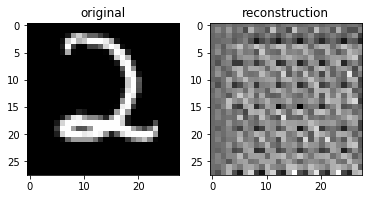

In [7]:
show_example(mnist.train.next_batch(1)[0][0], model, sess)

In [8]:
def train(model,  batch_size=128, n_train_steps=10000, evaluate_every_n_step=100):
    costs = []
    for step in range(n_train_steps):
        batch, _ = mnist.train.next_batch(batch_size)
        cost, _ = sess.run([model.loss, model.train_op], 
                           feed_dict={model.inputs: batch,
                                      model.learning_rate: 0.01})
        costs.append(cost)
        if step % evaluate_every_n_step == 0:
            print(np.mean(costs))
            costs = []

In [9]:
sess.run(model.initializer)

[None, None]

In [10]:
# This may take some time
train(model, 25, 5000, 200)

590.64056
219.76721
185.07993
171.86493
162.3646
158.01102
153.95346
151.7182
150.37498
148.06067
145.90903
145.89928
145.47763
143.54527
143.62505
142.13155
142.76855
141.9439
141.57884
140.40193
141.42615
140.83508
140.8761
140.12341
139.41673


In [11]:
a = mnist.train.next_batch(1)[0][0]

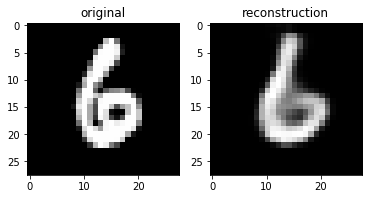

In [12]:
show_example(a, model, sess)

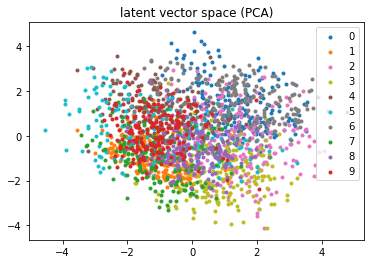

In [13]:
def show_latent_vector_space(model, sess):
    images, digits = mnist.test.next_batch(2000)
    latent_vector_mean = sess.run(model.mean, feed_dict={model.inputs: images})

    if len(latent_vector_mean[0]) > 2:
        # perform PCA
        from sklearn.decomposition import PCA
        pca = PCA(2)
        vectors = pca.fit(latent_vector_mean).transform(latent_vector_mean)
    else:
        # nothing to do
        vectors = latent_vector_mean

    colors =  {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
               'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
               'tab:olive', 'tab:cyan'} 
    for color, digit in zip(colors, range(10)):
        plt.scatter(vectors[digits == digit, 0], vectors[digits == digit, 1],
                    c=color, label=str(digit), marker='.')
    plt.legend()
    plt.title('latent vector space (PCA)')

    plt.show()
    
show_latent_vector_space(model, sess)

# The same for a simpler model, namely a fully-connected multi-layer perceptron. 
Here with two-dimensional latent-vector space

In [14]:
def encoder_simple(inputs, hidden_layer_sizes=[100, 10], output_dim=2):
    """ Gaussian encoder to 2-dimensional latent vector by fully connected MLP
    """
    with tf.variable_scope("hidden"):
        hidden_output = inputs
        for size in hidden_layer_sizes:
            hidden_output = tf.layers.dense(
                   hidden_output, size, tf.nn.softplus,
                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                   name=f'hidden_{size}')

    with tf.variable_scope("variational_param"):
        mean = tf.layers.dense(hidden_output, output_dim, name="mean",
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        std_dev = tf.layers.dense(hidden_output, output_dim, 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                   activation=tf.nn.softplus,
                                   name="std_dev")
        
    with tf.variable_scope("sample"):    
        sample = mean + tf.sqrt(std_dev) * tf.random_normal(tf.shape(std_dev))
        sample = tf.identity(sample, name="output")
    return sample, (mean, std_dev)


def decoder_simple(inputs, hidden_layer_sizes=[10, 100], output_dim=INPUT_DIM):
    """ Bernoulli decoder to 28**2-dimensional vector by fully connected MLP
    """
    inputs = tf.identity(inputs, name="inputs")
    with tf.variable_scope("hidden"):
        hidden_output = inputs
        for size in hidden_layer_sizes:
            hidden_output = tf.layers.dense(hidden_output, size, tf.nn.softplus,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name=f'hidden_{size}')
    with tf.variable_scope("variational_param"):
        mean = tf.layers.dense(hidden_output, output_dim, tf.nn.sigmoid)
        mean = tf.identity(mean, name="mean")
    with tf.variable_scope("sample"):    
        sample = mean * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)
        sample = tf.identity(sample, name="output")
    return sample, (mean,)

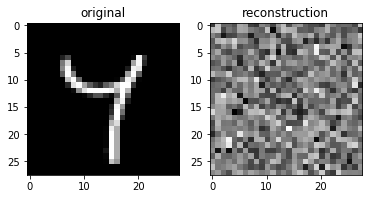

In [15]:
tf.reset_default_graph()
model = VariationalAutoEncoder(encoder_simple, decoder_simple)

sess = tf.Session()
sess.run(model.initializer)

show_example(mnist.train.next_batch(1)[0][0], model, sess)

In [16]:
train(model, 64, 8000, 500)

558.80884
185.38269
169.55545
166.56319
163.71902
161.90321
161.2954
160.4455
159.53423
158.95525
158.36415
158.2478
158.41454
157.64197
157.06631
157.43608


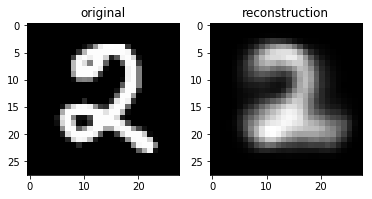

In [17]:
show_example(mnist.train.next_batch(1)[0][0], model, sess)

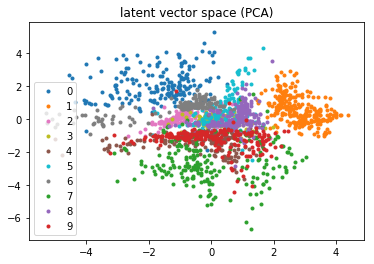

In [18]:
show_latent_vector_space(model, sess)